# Linear Speed & Neural Timescale Sweep

## Set up

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2
# jupyter black formatter
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "timescales"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /home/facosta/timescales/timescales
Directory added to path:  /home/facosta/timescales
Directory added to path:  /home/facosta/timescales/timescales


In [2]:
sweep_dir = "/home/facosta/timescales/timescales/logs/experiments/speed_alpha_grid_20251215_211710"
os.path.exists(sweep_dir)

True

Loading sweep from: /home/facosta/timescales/timescales/logs/experiments/speed_alpha_grid_20251215_211710
Loading 100 experiments with 1 seeds each...
Total models to load: 100
Using Lightning checkpoints

Loading experiment: speed_0.05_alpha_0.1
  ✓ Loaded speed_0.05_alpha_0.1/seed_0
Loading experiment: speed_0.05_alpha_0.2
  ✓ Loaded speed_0.05_alpha_0.2/seed_0
Loading experiment: speed_0.05_alpha_0.4
  ✓ Loaded speed_0.05_alpha_0.4/seed_0
Loading experiment: speed_0.05_alpha_0.5
  ✓ Loaded speed_0.05_alpha_0.5/seed_0
Loading experiment: speed_0.05_alpha_0.7
  ✓ Loaded speed_0.05_alpha_0.7/seed_0
Loading experiment: speed_0.05_alpha_0.9
  ✓ Loaded speed_0.05_alpha_0.9/seed_0
Loading experiment: speed_0.05_alpha_1.2
  ✓ Loaded speed_0.05_alpha_1.2/seed_0
Loading experiment: speed_0.05_alpha_1.6
  ✓ Loaded speed_0.05_alpha_1.6/seed_0
Loading experiment: speed_0.05_alpha_2.3
  ✓ Loaded speed_0.05_alpha_2.3/seed_0
Loading experiment: speed_0.05_alpha_1.0
  ✓ Loaded speed_0.05_alpha_1.0/s

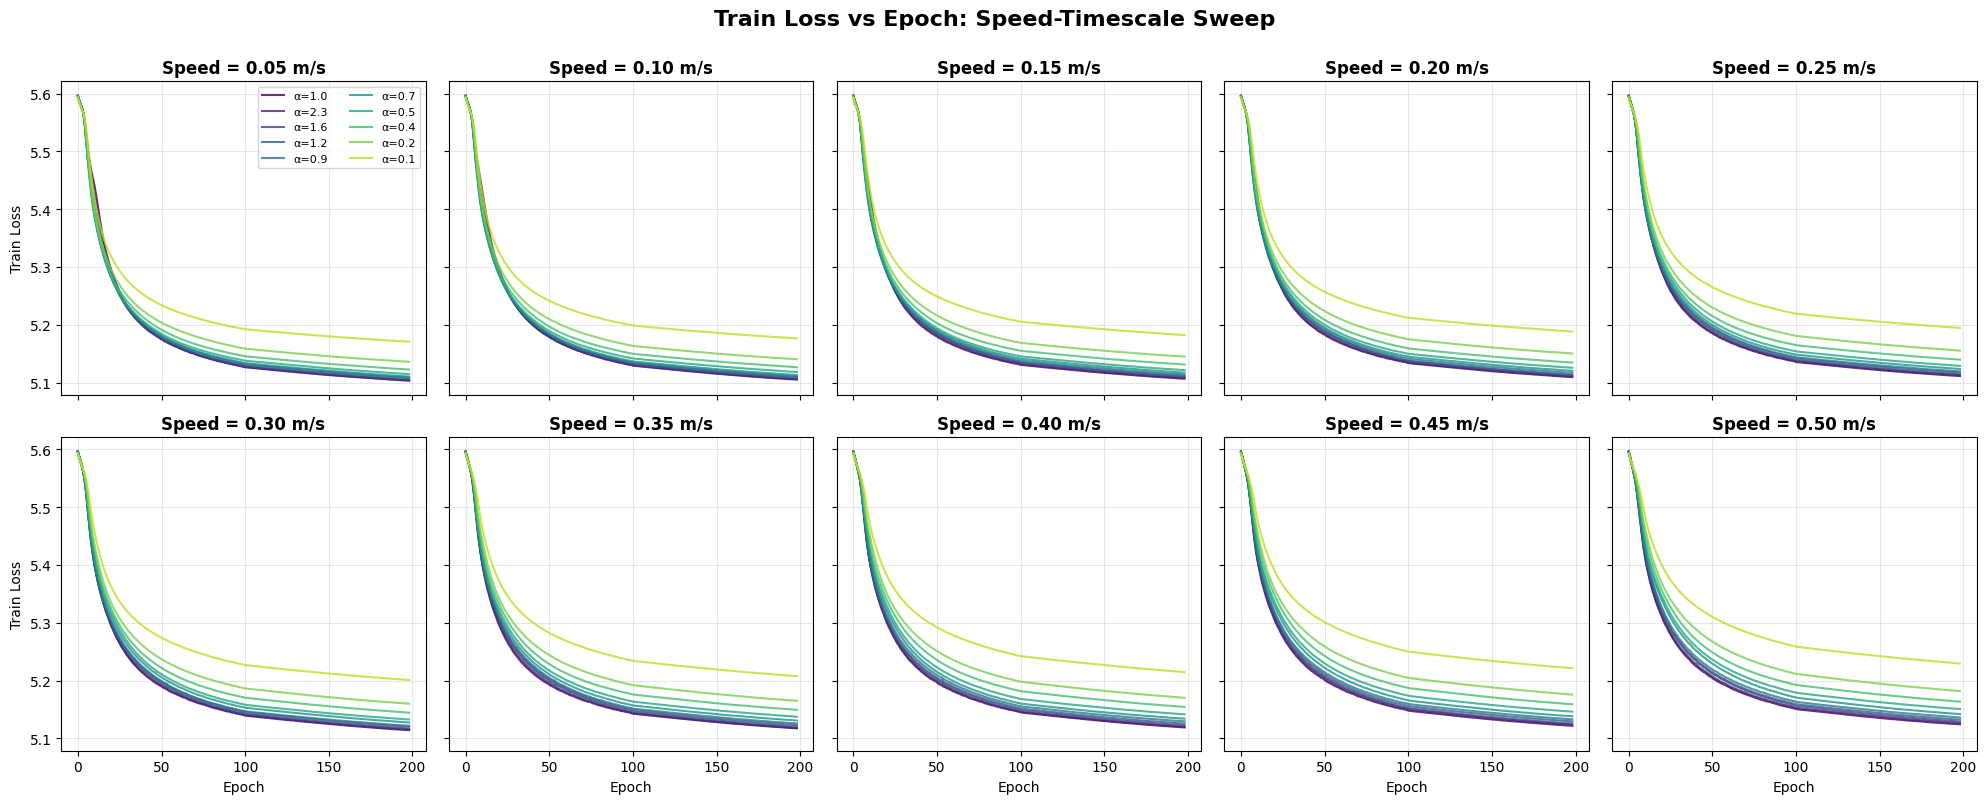

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from timescales.analysis.load_models import load_experiment_sweep
import torch
from collections import defaultdict
import re

# Configuration
sweep_dir = "/home/facosta/timescales/timescales/logs/experiments/speed_alpha_grid_20251215_211710"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Plotting options
use_log_x = False  # Set to True for log scale on x-axis (epochs)
use_log_y = False  # Set to True for log scale on y-axis (loss)
loss_type = "train"  # "train" or "val"

# Load the sweep
print(f"Loading sweep from: {sweep_dir}")
models, metadata, summary = load_experiment_sweep(
    sweep_dir=sweep_dir,
    device=device,
    use_lightning_checkpoint=True,
    checkpoint_type="best",
)

# Parse experiment names to extract speed and timescale
# Format: speed_0.05_alpha_0.1
data_by_speed = defaultdict(dict)  # {speed: {timescale: {seed: data}}}

for exp_name, seed_dict in models.items():
    # Parse experiment name
    match = re.match(r"speed_([\d.]+)_alpha_([\d.]+)", exp_name)
    if not match:
        print(f"Warning: Could not parse experiment name: {exp_name}")
        continue

    speed = float(match.group(1))
    alpha_from_name = float(match.group(2))  # Note: this is incorrect per user

    # Get actual timescale from config
    for seed, seed_data in seed_dict.items():
        config = seed_data["config"]
        timescale_values = config.get("timescales_config", {}).get("values", [])
        if timescale_values:
            timescale = timescale_values[0]  # Single timescale per experiment
        else:
            timescale = None

        if seed not in data_by_speed[speed]:
            data_by_speed[speed][timescale] = {}

        data_by_speed[speed][timescale][seed] = seed_data

# Get sorted lists of speeds and timescales
speeds = sorted(data_by_speed.keys())
all_timescales = sorted(
    set(
        ts
        for speed_data in data_by_speed.values()
        for ts in speed_data.keys()
        if ts is not None
    )
)

print(f"\nFound {len(speeds)} speeds: {speeds}")
print(
    f"Found {len(all_timescales)} timescales: {[f'{ts:.3f}' for ts in all_timescales]}"
)

# Compute actual alpha values from timescales
dt = 0.1  # From config
alphas = [dt / ts if ts > 0.001 else 1.0 for ts in all_timescales]
print(f"Corresponding alphas: {[f'{a:.1f}' for a in alphas]}")

# Create figure with 10 subplots (2 rows x 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Color map for timescales
cmap = plt.cm.viridis
colors = [cmap(i / len(all_timescales)) for i in range(len(all_timescales))]

# Plot each speed in a separate subplot
for idx, speed in enumerate(speeds):
    ax = axes[idx]

    # Plot each timescale as a separate curve
    for ts_idx, timescale in enumerate(all_timescales):
        if timescale not in data_by_speed[speed]:
            continue

        seed_dict = data_by_speed[speed][timescale]

        # Aggregate losses across seeds
        all_epochs = []
        all_losses = []

        for seed, seed_data in seed_dict.items():
            training_losses = seed_data.get("training_losses", {})
            if not training_losses:
                continue

            epochs = training_losses.get("epochs", [])
            if loss_type == "train":
                losses = training_losses.get("train_losses", [])
            else:
                losses = training_losses.get("val_losses", [])

            if epochs and losses:
                all_epochs.append(epochs)
                all_losses.append(losses)

        if not all_epochs:
            continue

        # Average across seeds (if multiple seeds exist)
        # For now, just plot the first seed (n_seeds=1 in config)
        epochs = all_epochs[0]
        losses = all_losses[0]

        # Plot
        alpha_val = alphas[ts_idx]
        ax.plot(
            epochs,
            losses,
            color=colors[ts_idx],
            label=f"α={alpha_val:.1f}",
            linewidth=1.5,
            alpha=0.8,
        )

    # Formatting
    ax.set_title(f"Speed = {speed:.2f} m/s", fontsize=12, fontweight="bold")
    ax.grid(True, alpha=0.3)

    if use_log_x:
        ax.set_xscale("log")
    if use_log_y:
        ax.set_yscale("log")

    # Only show legend for first subplot
    if idx == 0:
        ax.legend(fontsize=8, loc="upper right", ncol=2)

    # Labels
    if idx >= 5:  # Bottom row
        ax.set_xlabel("Epoch", fontsize=10)
    if idx % 5 == 0:  # Left column
        ax.set_ylabel(f"{loss_type.capitalize()} Loss", fontsize=10)

# Overall title
fig.suptitle(
    f"{loss_type.capitalize()} Loss vs Epoch: Speed-Timescale Sweep",
    fontsize=16,
    fontweight="bold",
    y=1.00,
)

plt.tight_layout()
plt.show()


Found 10 speeds: [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
Found 10 timescales: ['0.001', '0.043', '0.062', '0.083', '0.109', '0.144', '0.196', '0.280', '0.448', '0.949']
Corresponding alphas: ['1.0', '2.3', '1.6', '1.2', '0.9', '0.7', '0.5', '0.4', '0.2', '0.1']


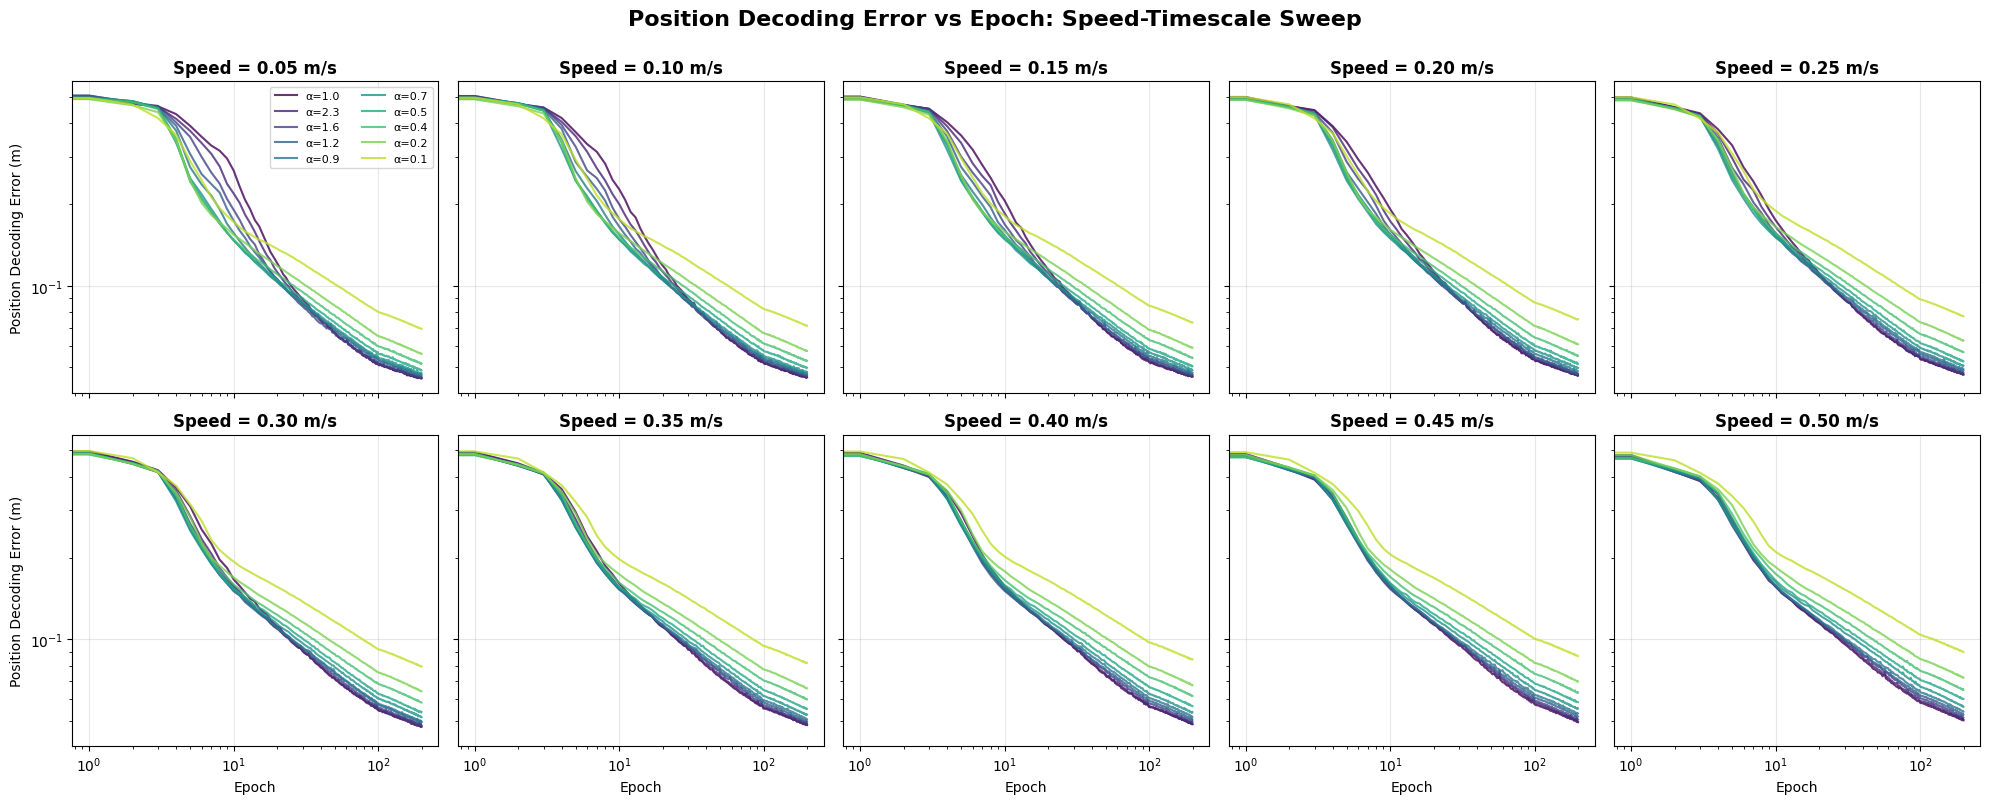

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from timescales.analysis.load_models import load_experiment_sweep
import torch
from collections import defaultdict
import re

# Configuration
sweep_dir = "/home/facosta/timescales/timescales/logs/experiments/speed_alpha_grid_20251215_211710"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Plotting options
use_log_x = True  # Set to True for log scale on x-axis (epochs)
use_log_y = True  # Set to True for log scale on y-axis (decoding error)

# # Load the sweep
# print(f"Loading sweep from: {sweep_dir}")
# models, metadata, summary = load_experiment_sweep(
#     sweep_dir=sweep_dir,
#     device=device,
#     use_lightning_checkpoint=True,
#     checkpoint_type="best",
# )

# Parse experiment names to extract speed and timescale
data_by_speed = defaultdict(dict)  # {speed: {timescale: {seed: data}}}

for exp_name, seed_dict in models.items():
    # Parse experiment name
    match = re.match(r"speed_([\d.]+)_alpha_([\d.]+)", exp_name)
    if not match:
        print(f"Warning: Could not parse experiment name: {exp_name}")
        continue

    speed = float(match.group(1))

    # Get actual timescale from config
    for seed, seed_data in seed_dict.items():
        config = seed_data["config"]
        timescale_values = config.get("timescales_config", {}).get("values", [])
        if timescale_values:
            timescale = timescale_values[0]
        else:
            timescale = None

        if seed not in data_by_speed[speed]:
            data_by_speed[speed][timescale] = {}

        data_by_speed[speed][timescale][seed] = seed_data

# Get sorted lists of speeds and timescales
speeds = sorted(data_by_speed.keys())
all_timescales = sorted(
    set(
        ts
        for speed_data in data_by_speed.values()
        for ts in speed_data.keys()
        if ts is not None
    )
)

print(f"\nFound {len(speeds)} speeds: {speeds}")
print(
    f"Found {len(all_timescales)} timescales: {[f'{ts:.3f}' for ts in all_timescales]}"
)

# Compute actual alpha values from timescales
dt = 0.1  # From config
alphas = [dt / ts if ts > 0.001 else 1.0 for ts in all_timescales]
print(f"Corresponding alphas: {[f'{a:.1f}' for a in alphas]}")

# Create figure with 10 subplots (2 rows x 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Color map for timescales
cmap = plt.cm.viridis
colors = [cmap(i / len(all_timescales)) for i in range(len(all_timescales))]

# Plot each speed in a separate subplot
for idx, speed in enumerate(speeds):
    ax = axes[idx]

    # Plot each timescale as a separate curve
    for ts_idx, timescale in enumerate(all_timescales):
        if timescale not in data_by_speed[speed]:
            continue

        seed_dict = data_by_speed[speed][timescale]

        # Aggregate decoding errors across seeds
        all_epochs = []
        all_errors = []

        for seed, seed_data in seed_dict.items():
            decoding_errors = seed_data.get("position_decoding_errors", {})
            if not decoding_errors:
                continue

            epochs = decoding_errors.get("epochs", [])
            errors = decoding_errors.get("position_errors_epoch", [])

            if epochs and errors:
                all_epochs.append(epochs)
                all_errors.append(errors)

        if not all_epochs:
            continue

        # Average across seeds (if multiple seeds exist)
        # For now, just plot the first seed (n_seeds=1 in config)
        epochs = all_epochs[0]
        errors = all_errors[0]

        # Plot
        alpha_val = alphas[ts_idx]
        ax.plot(
            epochs,
            errors,
            color=colors[ts_idx],
            label=f"α={alpha_val:.1f}",
            linewidth=1.5,
            alpha=0.8,
        )

    # Formatting
    ax.set_title(f"Speed = {speed:.2f} m/s", fontsize=12, fontweight="bold")
    ax.grid(True, alpha=0.3)

    if use_log_x:
        ax.set_xscale("log")
    if use_log_y:
        ax.set_yscale("log")

    # Only show legend for first subplot
    if idx == 0:
        ax.legend(fontsize=8, loc="upper right", ncol=2)

    # Labels
    if idx >= 5:  # Bottom row
        ax.set_xlabel("Epoch", fontsize=10)
    if idx % 5 == 0:  # Left column
        ax.set_ylabel("Position Decoding Error (m)", fontsize=10)

# Overall title
fig.suptitle(
    "Position Decoding Error vs Epoch: Speed-Timescale Sweep",
    fontsize=16,
    fontweight="bold",
    y=1.00,
)

plt.tight_layout()
plt.show()